# Exploring precision and recall

In [1]:
#Libraries Import
import json
import string
import numpy as np
import pandas as pd
import scikitplot as skplt
from math import exp,log,sqrt
import matplotlib.pyplot as plt
pd.set_option("Chained_Assignment",None)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#read dataframe
products=pd.read_csv("amazon_baby.csv")

In [3]:
#replace null values with empty string
products = products.fillna({'review':''})
#remove punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator) 

products["review_without_punctuation"] = products['review'].apply(lambda x : remove_punctuation(x))
products=products[["name","review_without_punctuation","rating"]]

In [4]:
# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

#test-train data
with open('module-9-assignment-test-idx.json') as test_data_file:    
    test_data_idx = json.load(test_data_file)
with open('module-9-assignment-train-idx.json') as train_data_file:    
    train_data_idx = json.load(train_data_file)

train_data = products.iloc[train_data_idx]
test_data = products.iloc[test_data_idx]


In [5]:
#Build the word count vector for each review_without_punctuations
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train_data['review_without_punctuation'])
test_matrix = vectorizer.transform(test_data['review_without_punctuation'])


In [6]:
#Logistic model fit
sentiment_model = LogisticRegression(solver='liblinear',n_jobs=1)
sentiment_model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
accuracy=accuracy_score(sentiment_model.predict(test_matrix),test_data["sentiment"].values)
print ("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9322954163666907


In [8]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


# QUIZ Exploring precision and recall

#### Question 1
Consider the logistic regression model trained on amazon_baby.gl using GraphLab Create.

Using accuracy as the evaluation metric, was our logistic regression model better than the majority class classifier?

__Ans__: Yes

#### Question 2
How many predicted values in the test set are false positives?

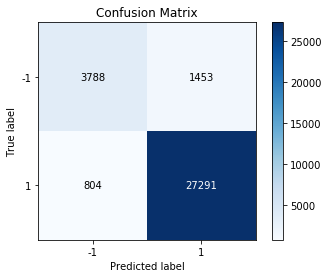

In [10]:
skplt.metrics.plot_confusion_matrix(test_data["sentiment"].values,sentiment_model.predict(test_matrix))
plt.show()

__Ans__: 1453

#### Question 3
Consider the scenario where each false positive costs $100 and each false negative $1.
Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the test set?


__Ans__: Between $100,000 and $200,000

In [11]:
false_positive=1453
false_negative=804
true_positive=27291
true_negative=3788
print("Total Cost: ",(false_positive*100)+(false_negative*1))

Total Cost:  146104


In [12]:
precision = round((true_positive/(true_positive+false_positive)),2)
print ("Precision on test data: %s" % precision)

Precision on test data: 0.95


#### Question 4
Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)

In [13]:
round(false_positive/(true_positive+false_positive),2)

0.05

__Ans__: 0.05

#### Question 5
Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would:


__Ans__: Increase threshold for predicting the positive class (y=+1)

#### Question 6
What fraction of the positive reviews in the test_set were correctly predicted as positive by the classifier? Round your answer to 2 decimal places.

In [14]:
recall = round(true_positive/(true_positive+false_negative),2)
print ("Recall on test data: %s" % recall)

Recall on test data: 0.97


__Ans__: 0.97

#### Question 7
What is the recall value for a classifier that predicts +1 for all data points in the test_data?

__Ans__: 1

#### Question 8
What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

In [15]:
# Varying the threshold
def apply_threshold(probabilities, threshold):
    # +1 if >= threshold and -1 otherwise.
    values = np.ones(len(probabilities))
    values[probabilities < threshold] = -1
    return values

In [16]:
probabilities = sentiment_model.predict_proba(test_matrix)[:,1]
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [17]:
 print ("Number of positive predicted reviews (threshold = 0.5): %s" % np.asarray(predictions_with_default_threshold == 1,dtype=int).sum())

Number of positive predicted reviews (threshold = 0.5): 28744


In [18]:
print ("Number of positive predicted reviews (threshold = 0.9): %s" % np.asarray(predictions_with_high_threshold == 1,dtype=int).sum())

Number of positive predicted reviews (threshold = 0.9): 25069


__Ans__:Fewer reviews are predicted to be positive.

#### Question 9
Consider the metrics obtained from setting the threshold to 0.5 and to 0.9.
Does the recall increase with a higher threshold?

In [19]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(test_data['sentiment'].values, predictions_with_default_threshold)
recall_with_default_threshold = recall_score(test_data['sentiment'].values, predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = precision_score(test_data['sentiment'].values, predictions_with_high_threshold)
recall_with_high_threshold = recall_score(test_data['sentiment'].values,predictions_with_high_threshold)

In [20]:
print ("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print ("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.9494503200667965
Recall (threshold = 0.5)   : 0.9713828083288841


In [21]:
print ("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print ("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 0.9814910846064862
Recall (threshold = 0.9)   : 0.8757786082932906


__Ans__: No

#### Question 10
Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [22]:
#Precision-recall curve
threshold_values = np.linspace(0.5, 1, num=100)
print (threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [23]:
precision_all = []
recall_all = []

probabilities = sentiment_model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(test_data['sentiment'].values, predictions)
    recall = recall_score(test_data['sentiment'].values, predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

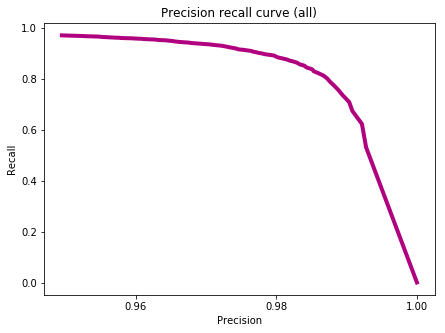

In [24]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [25]:
print (round((min(np.array(threshold_values)[np.array(precision_all) >= 0.965])),3))

0.707


__Ans__: 0.707

#### Question 11
Using threshold = 0.98, how many false negatives do we get on the test_data? (Hint: You may use the graphlab.evaluation.confusion_matrix function implemented in GraphLab Create.)


In [26]:
predictions_with_new_threshold = apply_threshold(probabilities, 0.98)
false_negatives = np.asarray((np.array(test_data['sentiment'].values) > 0) * (predictions_with_new_threshold < 0)).sum()
print (false_negatives)


8209


__Ans__: 8209

#### Question 12
Questions 13 and 14 are concerned with the reviews that contain the word baby.

Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better for the reviews of data in baby_reviews? Round your answer to 3 decimal places.

In [27]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]
baby_matrix = vectorizer.transform(baby_reviews['review_without_punctuation'])
probabilities = sentiment_model.predict_proba(baby_matrix)[:,1]
threshold_values = np.linspace(0.5, 1, num=100)
precision_all = []
recall_all = []

probabilities = sentiment_model.predict_proba(baby_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(baby_reviews['sentiment'].values, predictions)
    recall = recall_score(baby_reviews['sentiment'].values, predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

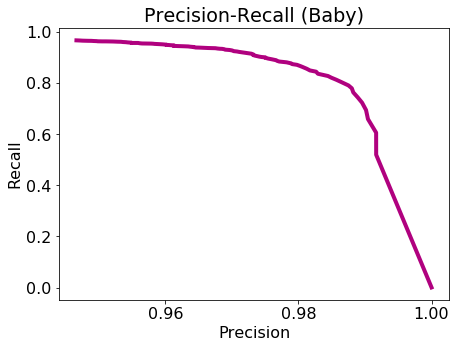

In [28]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")

In [29]:
print (round((min(np.array(threshold_values)[np.array(precision_all) >= 0.965])),3))

0.732


__Ans__: 0.732

#### Question 13
Questions 13 and 14 are concerned with the reviews that contain the word baby.

Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

__Ans__: Larger